# Deep Q-Network (DQN)

### 0.Background: introduce Deep learning to RL

Before the introduction of DQN, reinforcement learning (RL) had already achieved some successes but was mainly limited to the following two scenarios:

1. **Low-Dimensional State Spaces:** Traditional RL methods, such as Q-learning, performed well in low-dimensional state spaces because Q-values could be stored and updated directly using tables or simple function approximators.
2. **Handcrafted Features:** In high-dimensional state spaces (e.g., image inputs), the success of RL relied on expert-designed feature extraction methods to convert high-dimensional inputs into low-dimensional representations.

However, these approaches faced significant challenges when applied to complex, high-dimensional environments (e.g., game images):

- **State Space Explosion:** High-dimensional states, such as pixel-level images, cannot be directly represented using Q-value tables.
- **Feature Engineering Bottleneck:** Handcrafted features require domain knowledge and are difficult to generalize across different tasks.

At the same time, the rapid advancement of deep learning, particularly the success of convolutional neural networks (CNNs) in image feature extraction, made it possible to automatically extract features from high-dimensional data. This laid the foundation for combining deep learning with reinforcement learning to address these challenges.

Basically, in DQN we have:

1. **In order to capture temporal information, a stack of 4 preprocessed frames are used as the state that is passed to the DQN.**

2. **The DQN takes the state as input, and returns the corresponding predicted action values for each possible game action.**

3. **The DQN architecture is composed of a couple of convolutional layers, followed by a couple of fully connected layers.**

4. **For each Atari game, the DQN was trained from scratch on that game.**

### 1. Import the Necessary Packages

In this notebook, we will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

In [13]:
import random
import numpy as np

from collections import namedtuple, deque
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# for game rendering
import time
from PIL import Image
from IPython import display

from plot_utils import plot_scores

device = torch.device("cuda:0" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
print(f"Training on: {device}")

%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=3, linewidth=120)

Training on: cpu


### 2. Explore Environment

<div style="text-align: center;">
    <img src="./images/lunar_lander.gif" alt="Mountain Car Environment" width="50%">
</div>

#### Discreate Action Space

There are four discrete actions available:

- 0: do nothing
- 1: fire left orientation engine
- 2: fire main engine
- 3: fire right orientation engine

#### Continuous Observation Space

The state is an 8-dimensional vector: 

- the coordinates of the lander in `x`
- the coordinates of the lander in`y`, 
- linear velocities in `x` 
- linear velocities in `y`, 
- its angle, 
- its angular velocity, and 
- a booleans that represent whether `left` leg is in contact with the ground or not.
- a booleans that represent whether `right` leg is in contact with the ground or not.

In [14]:
env = gym.make('LunarLander-v3', render_mode="rgb_array")

In [15]:
# Explore state (observation) space
print("State space:\n", env.observation_space)
print(" - low:", env.observation_space.low)
print(" - high:", env.observation_space.high)

# Explore action space
print("Action space:\n", env.action_space)

print("-"*50)
# Generate some samples from the state space 
print("State space 10 samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

# Generate some samples from the action space
print("Action space 10 samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

State space:
 Box([ -2.5    -2.5   -10.    -10.     -6.283 -10.     -0.     -0.   ], [ 2.5    2.5   10.    10.     6.283 10.     1.     1.   ], (8,), float32)
 - low: [ -2.5    -2.5   -10.    -10.     -6.283 -10.     -0.     -0.   ]
 - high: [ 2.5    2.5   10.    10.     6.283 10.     1.     1.   ]
Action space:
 Discrete(4)
--------------------------------------------------
State space 10 samples:
[[-2.474e+00  4.716e-02  9.524e+00  8.143e+00 -2.753e+00 -5.758e-01  9.726e-01  3.635e-02]
 [ 6.360e-01 -1.130e+00  5.498e+00 -7.500e-01  1.431e+00 -1.942e+00  6.606e-01  5.796e-01]
 [-2.178e+00 -1.756e+00  4.351e+00  8.808e+00 -8.335e-01 -5.530e+00  7.032e-02  1.992e-01]
 [ 7.891e-01 -1.936e+00 -4.616e+00 -6.639e+00  6.266e+00 -5.952e+00  8.044e-01  3.017e-01]
 [ 2.281e-03 -1.054e+00 -4.812e+00 -9.648e+00  1.591e+00 -7.369e+00  9.503e-01  5.206e-01]
 [-1.005e+00  8.770e-01  1.399e+00  9.697e-01  4.765e+00  4.609e+00  9.145e-03  1.773e-01]
 [ 2.085e+00  2.418e+00 -5.838e+00  6.091e+00 -1.882

### 3. Define Replay Buffer

#### Using Experience Replay Improve Training Stability

<div style="text-align: center;">
    <img src="./images/reply-buffer.png" alt="Mountain Car Environment" width="70%">
</div>

When an agent interacts with the environment, the sequence of experience tuples can be highly correlated, which poses a risk for naive Q-learning algorithms. These algorithms, when learning sequentially from such correlated data, may lead to unstable updates, causing action values to oscillate or diverge.

To address this, a replay buffer is introduced to store experience tuples $(S, A, R, S')$ collected during interactions with the environment. By using **experience replay**, small batches of tuples are randomly sampled from the buffer for training. This random sampling breaks harmful correlations, stabilizes learning, and allows the agent to:  
1. Reuse individual experience tuples multiple times.  
2. Recall rare events.  
3. Make better overall use of past experiences.  

Experience replay thus improves the efficiency and stability of the learning process.

In [16]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            batch_size (int): size of each training batch
            buffer_size (int): maximum size of buffer
            seed (int): random seed
        """
        self.action_size = action_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple(
            "Experience",
            field_names=["state", "action", "reward", "next_state", "done"],
        )
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def _to_tensor(self, data, dtype=torch.float):

        """Convert numpy array to tensor with specified dtype and device in one operation"""
        return torch.from_numpy(np.vstack(data)).to(device=device, dtype=dtype)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, k=self.batch_size)
        experiences = [e for e in experiences if e is not None]
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = self._to_tensor(states)
        actions = self._to_tensor(actions, dtype=torch.long)
        rewards = self._to_tensor(rewards)
        next_states = self._to_tensor(next_states) 
        dones = self._to_tensor(dones, dtype=torch.uint8)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [17]:
# Simulate Experience Replay How to Works
buffer = ReplayBuffer(action_size=env.action_space.n, buffer_size=10, batch_size=2, seed=42)
state, _ = env.reset()
for i in range(5):
	action = env.action_space.sample()
	next_state, reward, done, _, _ = env.step(action)
	buffer.add(state, action, reward, next_state, done)
print(f"Current Buffer Size: {len(buffer)}")
print("Sample one batch:")
batches = buffer.sample()
states, actions, rewards, next_states, dones = batches
print(f" States Size: {states.shape}, \n Actions Size: {actions.shape}, "
	  f"\n Rewards Size: {rewards.shape}, \n Next States Size: {next_states.shape}"
	  f"\n Dones Size: {dones.shape}"
)

Current Buffer Size: 5
Sample one batch:
 States Size: torch.Size([2, 8]), 
 Actions Size: torch.Size([2, 1]), 
 Rewards Size: torch.Size([2, 1]), 
 Next States Size: torch.Size([2, 8])
 Dones Size: torch.Size([2, 1])


### 4. Define Q Network

#### Using Neural Networks as Approximators for Q values

<div style="text-align: center;">
    <img src="./images/model-view.png" alt="Mountain Car Environment" width="70%">
</div>

This image shows the transition from a **Traditional Q Table** to a **Parameterized Q Function** in reinforcement learning. 

The Q table (left) stores discrete Q-values $ Q(s_t, a_t) $ for each state-action pair but struggles with scalability in high-dimensional spaces. The parameterized Q function (right) replaces the table with a neural network $ Q(s_t, a_t; w) $, where $ w $ are the network's parameters.

<div style="text-align: center;">
    <img src="./images/model-arch.png" alt="Mountain Car Environment" width="70%">
</div>

- Define a neural network architecture that maps states to action values $Q(s_t, a_t; w)$.


In [18]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, hidden_size=64, seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.Q = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, state):
        """Build a network that maps state -> action values."""
        actions = self.Q(state)
        return actions


# test model
q_net = QNetwork(8, 4, 16, seed=42)
# fake input, by given batch size 4
states = torch.rand((4, 8))
# fake output size
print(q_net(states).shape)

torch.Size([4, 4])


### 5. Define Agent

##### How to Learn in DQN

<div style="text-align: center;">
    <img src="./images/dqn-gradient-descent.png" alt="Mountain Car Environment" width="70%">
</div>

This image provides a visual summary of the core theory and update mechanism of **Deep Q-Network (DQN)**, showcasing the key formula derivations from **Q-Learning** to **DQN**, as well as how neural networks are used to approximate and update Q-values.

---

**1. Core Idea Based on the Bellman Equation**
- **Bellman Equation:**
  $$
  Q^*(s_t, a_t) = R_t + \gamma \max_a Q^*(s_{t+1}, a)
  $$
  - This states that the optimal Q-value for the current state-action pair equals the immediate reward $ R_t $ plus the discounted maximum Q-value of the next state.
  - The core objective of DQN is to approximate this equation using a neural network.

**2. Derivation from Q-Learning to DQN**
- **Q-Learning Update Formula:**
  $$
  Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( R_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right)
  $$
  - **TD Target:**
    $$
    R_t + \gamma \max_a Q(s_{t+1}, a)
    $$
    This represents the target Q-value for the current state, combining the immediate reward $ R_t $ and the maximum Q-value of the next state.
  - **Current Value:**
    $$
    Q(s_t, a_t)
    $$
    This is the current estimated Q-value.
  - **TD Error:**
    $$
    \delta_t = \left( R_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right)
    $$
    This measures the difference between the target Q-value and the current Q-value.

- **Neural Network Introduction:**
  - To handle continuous state spaces, DQN replaces the traditional Q-table with a neural network $ Q(s, a; w) $, where $ w $ represents the network parameters.
  - The goal is to optimize the network so that its output $ Q(s, a; w) $ approximates the true $ Q^*(s, a) $.


**3. Loss Function and Gradient Update in DQN**
- **Loss Function:**
  $$
  L(w) = \frac{1}{2} \left[ Q(s_t, a_t; w) - Q^*(s_t, a_t) \right]^2
  $$
  - Here, $ Q^*(s_t, a_t) $ is the target Q-value (TD Target) calculated using the Bellman equation.
  - The loss function minimizes the squared error between the network's output $ Q(s_t, a_t; w) $ and the target Q-value $ Q^*(s_t, a_t) $.

- **Gradient Calculation:**
  $$
  \nabla_w L(w) = \left( Q(s_t, a_t; w) - Q^*(s_t, a_t) \right) \nabla_w Q(s_t, a_t; w)
  $$
  - The gradient consists of two parts:
    1. The error term: $ Q(s_t, a_t; w) - Q^*(s_t, a_t) $
    2. The gradient of the network output: $ \nabla_w Q(s_t, a_t; w) $

- **Weight Update:**
  $$
  w \leftarrow w - \alpha \nabla_w L(w)
  $$
  - Using gradient descent, the network parameters $ w $ are updated to reduce the loss function.

- **Final DQN Update Formula:**
  $$
  L(w) = \frac{1}{2} \left[ Q(s_t, a_t; w) - (R_t + \gamma \max_a Q(s_{t+1}, a; w^-)) \right]^2
  $$

  $$
  w' \leftarrow w + \alpha \left( R_t + \gamma \max_a Q(s_{t+1}, a; w^-) - Q(s_t, a_t; w) \right) \nabla_w Q(s_t, a_t; w)
  $$
  - Here, $ w^- $ represents the fixed target network parameters during the learning step, which are used to stabilize training.


In [19]:
class Agent:
    """Interacts with and learns from the environment."""

    def __init__(
        self,
        env,
        hidden_size=64,
        buffer_size=int(1e5),
        batch_size=64,
        gamma=0.99,
        alpha=1e-3,
        lr=5e-4,
        update_step=4,
        seed=42,
    ):
        """Initialize an Agent object.

        Params
        ======
            buffer_size (int): replay buffer size
            batch_size (int): minibatch size
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): soft update of target parameters
            update_step (int): how often to update the network
            seed (int): random seed

        """
        self.seed = random.seed(seed)

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.lr = lr
        self.gamma = gamma
        self.alpha = alpha
        self.update_step = update_step

        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n

        # Q-Network
        self.Q = QNetwork(self.state_size, self.action_size, hidden_size, seed).to(device)
        self.Q_target = QNetwork(self.state_size, self.action_size, hidden_size, seed).to(device)
        self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

        # Replay memory
        self.memory = ReplayBuffer(
            self.action_size, self.buffer_size, self.batch_size, seed
        )
        # Initialize time step (for updating every update step)
        self.t_step = 0

    def __repr__(self):
        return (
            f"Q Network Arch: {self.Q}\n"
            f"State space size: {self.state_size}\n"
            f"Action space size: {self.action_size}\n"
            f"Current Memory size: {len(self.memory)}"
        )

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every update_step time steps.
        self.t_step = (self.t_step + 1) % self.update_step
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def select_action(self, state, epsilon=0.0):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.Q.eval()
        with torch.no_grad():
            actions = self.Q(state)
        self.Q.train()

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            return np.argmax(actions.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        self.optimizer.zero_grad()

        # get experiences
        states, actions, rewards, next_states, dones = experiences
        
        # compute td targets using target network
        with torch.no_grad():
            Q_targets_next = torch.max(self.Q_target(next_states), dim=-1, keepdim=True)[0]
            Q_targets = rewards + (1-dones) * self.gamma * Q_targets_next
        
        # compute curr values using local network
        Q_expected = torch.gather(self.Q(states), dim=-1, index=actions)
    
        # compute mean squared loss using td error
        loss = F.mse_loss(Q_expected, Q_targets)
        loss.backward()
        
        # update local network parameters
        self.optimizer.step()

        # update target network parameters
        self.soft_update()

    def soft_update(self):
        """Soft update model parameters.
        θ_target = alpha*θ + (1 - alpha)*θ_target
        =>
        θ_target = θ_target + alpha*(θ - θ_target)

        Params
        ======
            Q (PyTorch model): weights will be copied from
            Q_target (PyTorch model): weights will be copied to
            alpha (float): interpolation parameter
        """
        for target_param, local_param in zip(
            self.Q_target.parameters(), self.Q.parameters()
        ):
            target_param.data.copy_(
                target_param.data + self.alpha * (local_param.data - target_param.data)
            )


In [20]:
agent = Agent(
	env,
	buffer_size=int(1e5),
	batch_size=64,
	gamma=0.99,
	alpha=1e-3,
	lr=5e-4,
	update_step=4,
	seed=42,
)
agent

Q Network Arch: QNetwork(
  (Q): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)
State space size: 8
Action space size: 4
Current Memory size: 0

### 6. Check Random Agent

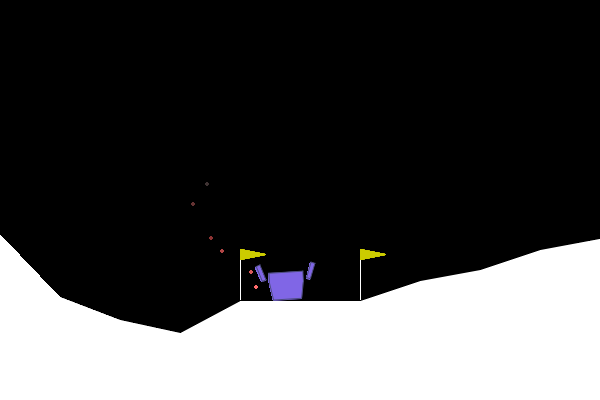

In [21]:
state, info = env.reset(seed=505)
for t in range(500):
    # clear frame
    display.clear_output(wait=True)

    action = agent.select_action(state)

    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.05)

    state, reward, done, _, info = env.step(action)
    if done:
        break
        
env.close()

### 7. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

In [22]:
def dqn(
    env,
    agent,
    n_episodes=2000,
    window=100,
    max_t=1000,
    epsilon=1.0,
    eps_min=0.01,
    eps_decay=0.995,
):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        epsilon (float): starting value of epsilon, for epsilon-greedy action selection
        eps_min (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    # list containing scores from each episode
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, n_episodes + 1):
        
        # get init state
        state, _ = env.reset()
        
        # run each episode
        total_reward = 0
        for t in range(max_t):
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        
        # save current episode total score    
        scores.append(total_reward)  
        
        # Update epsilon
        epsilon = max(eps_min, eps_decay * epsilon)  # decrease epsilon

        # Print episode stats
        if len(scores) > window:
            avg_score = np.mean(scores[-window:])
            if avg_score > max_avg_score:
                max_avg_score = avg_score

        if i_episode % window == 0:
            print(
                "\rEpisode {}/{} | Max Average Score: {:.2f}".format(
                    i_episode, n_episodes, max_avg_score
                ),
            )

        if max_avg_score >= 200.0:
            print(
                "\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}".format(
                    i_episode - 100, max_avg_score
                )
            )
            torch.save(agent.Q.state_dict(), "checkpoint.pth")
            break
    return scores


scores = dqn(
    env,
    agent,
    n_episodes=2000,
    window=100,
    max_t=1000,
    epsilon=1.0,
    eps_min=0.01,
    eps_decay=0.995,
)

Episode 100/2000 | Max Average Score: -inf
Episode 200/2000 | Max Average Score: -106.08
Episode 300/2000 | Max Average Score: -45.46
Episode 400/2000 | Max Average Score: 10.12
Episode 500/2000 | Max Average Score: 64.95
Episode 600/2000 | Max Average Score: 169.84
Episode 700/2000 | Max Average Score: 192.05

Environment solved in 632 episodes!	Average Score: 200.53


0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
727    199.732911
728    199.931392
729    199.897160
730    199.695707
731    200.533954
Length: 732, dtype: float64

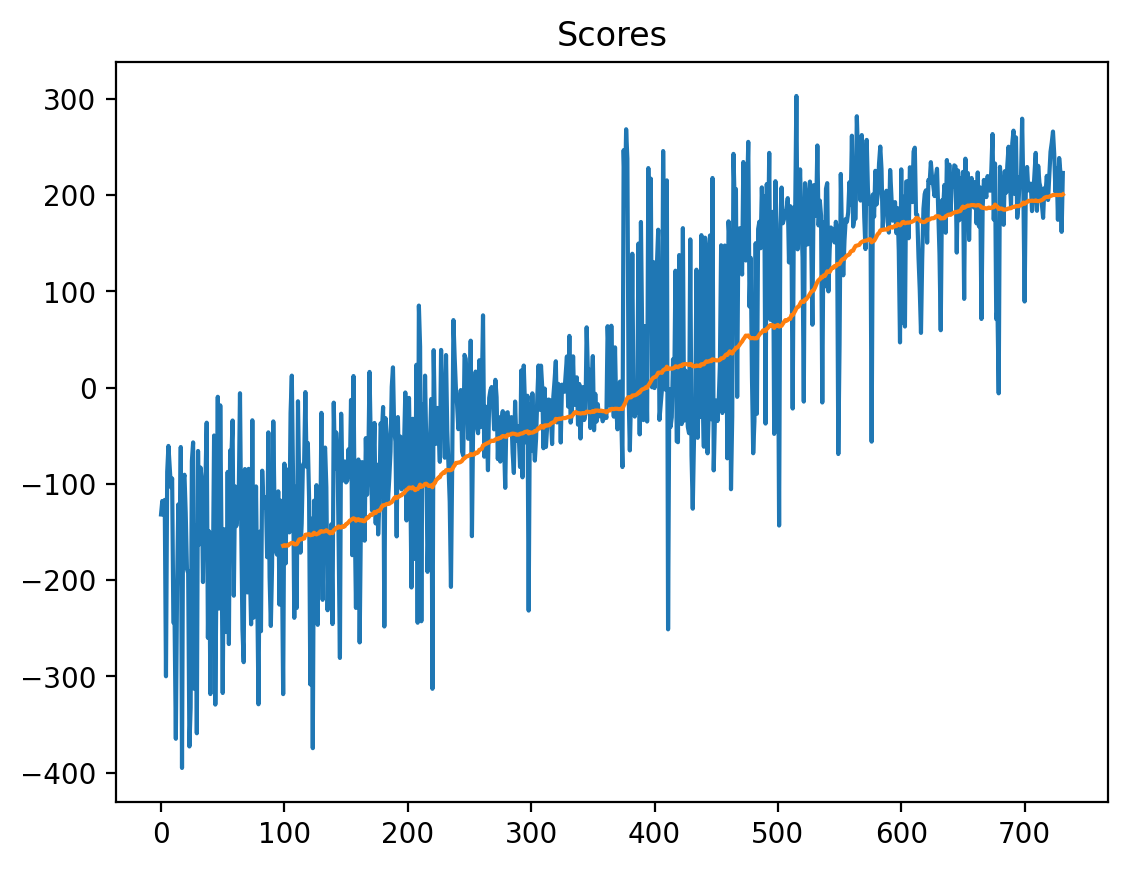

In [23]:
plot_scores(scores)

### 8. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

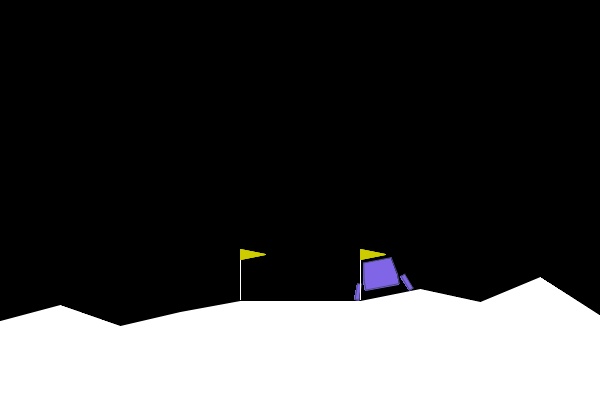

Final score: 185.44107227580864
Average score: 170.94116206939808


In [26]:
# load the weights from file
agent.Q.load_state_dict(torch.load('checkpoint.pth'))

env = gym.make("LunarLander-v3", render_mode="rgb_array")

avg_score = 0
for i in range(3):
	state, info = env.reset()
	total_reward = 0
	for t in range(500):
		# clear frame
		display.clear_output(wait=True)

		action = agent.select_action(state)

		# render game
		frame = env.render()
		display.display(Image.fromarray(frame))
		time.sleep(0.05)

		state, reward, done, _, info = env.step(action)
		total_reward += reward
		if done:
			break
	
	avg_score += total_reward
	print('Final score:', total_reward)
env.close()
print(f"Average score: {avg_score / 3}")

### 9. Prioritized Experience Replay

- TODO:

### 10. Discussion

- TODO: add content of discuss about Double DQN, or Dueling DQN and hyperlink of next notebook